In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from dask.distributed import Client
import dask
import xarray as xr
import xgcm
from dask.diagnostics import ProgressBar
import sys
import matplotlib.patches as patches
sys.path.append('/homes/metofac/wenegrat/xroms/')
sys.path.append('/homes/metofac/wenegrat/pyspec/')

#from xroms import open_roms_netcdf_dataset
import cmocean.cm as cmo
import xroms
from pyspec import spectrum as spec
from scipy import integrate as integrate
from timeit import default_timer as timer

#%%
plt.rcParams['text.usetex'] = False
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 14
plt.rcParams['contour.negative_linestyle'] = 'solid'

import sys
sys.path.append("../src/")
import load_model_runs as lruns

from importlib import reload  
import time

/homes/metofac/wenegrat/xroms/xroms/interp.py:18: UserWarning: xESMF is not installed, so `interpll` will not run.
  warnings.warn("xESMF is not installed, so `interpll` will not run.")


In [2]:
client = Client(processes=False)#Client(memory_limit='312GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://128.8.216.13:8787/status,
Dashboard: http://128.8.216.13:8787/status,Workers: 1
Total threads: 128,Total memory: 503.40 GiB
Status: running,Using processes: False
Comm: inproc://128.8.216.13/55435/1,Workers: 1
Dashboard: http://128.8.216.13:8787/status,Total threads: 128
Started: Just now,Total memory: 503.40 GiB
Comm: inproc://128.8.216.13/55435/4,Total threads: 128
Dashboard: http://128.8.216.13:36287/status,Memory: 503.40 GiB
Nanny: None,


In [3]:

def loadNewRun(filename, chunks, avg=False):
    # note here that filename should be the directory of history files
    from glob import glob

    
    if avg:
        files = sorted(glob(filename+'jet_avg.*.nc'))
    else:
        files = sorted(glob(filename+'jet_his.*.nc'))
    dsWC = xr.open_mfdataset(files, combine='nested', concat_dim='time', data_vars='minimal', chunks=chunks, coords='minimal', compat='override', parallel=True)

    ds = xr.open_dataset('../data/model/jet_his.nc')

    # For some reason I have to correct the grid metrics that aren't being output with this CROCO run.
    #dsWC['s_rho'] = ('s_rho', ds.s_rho)
    #dsWC['s_w'] = ('s_w', ds.s_w)
    #dsWC['Cs_r'] = ds.Cs_r
    #dsWC['Cs_w'] = ds.Cs_w
    #dsWC['h'] = (('eta_rho', 'xi_rho'), 4000  + 0*dsWC.zeta.isel(time=0))
    #dsWC['pm'] = (('eta_rho', 'xi_rho'), 1/500 + 0*dsWC.zeta.isel(time=0))
    #dsWC['pn'] = (('eta_rho', 'xi_rho'), 1/500 + 0*dsWC.zeta.isel(time=0))
    #dsWC['pm_u'] = (('eta_rho', 'xi_u'), 1/500 + 0*dsWC.u.isel(time=0, s_rho=0))
    #dsWC['pn_v'] = (('eta_v', 'xi_rho'), 1/500 + 0*dsWC.v.isel(time=0, s_rho=0))

    #dsWC['f'] = dsNC.f ## XXX THIS IS A HACK THAT WON"T ALWAYS WORK
    #dsWC = dsWC.rename(time='ocean_time')
    print('here')
    dsWC, grid = xroms.roms_dataset(dsWC, Vtransform=1) ### IS THIS CORRECT???? NEED TO VERIFY!!
    print('and here')
    dsWC['rho'] = dsWC.temp
    dsWC = dsWC.swap_dims({'time':'ocean_time'})
    dsWC['temp'] = (-(1000+dsWC.rho)/(1000+dsWC.rho.isel(ocean_time=1, s_rho=-1).mean()) + 1)/2e-4 + 20
    return dsWC, grid

In [4]:
chunks={'time':1}

runname = 'JET_NML_CFB'
dsWC, gridWC = loadNewRun('../data/model/'+runname+'/', chunks=chunks, avg=False)
dsWC

runname = 'JET_NML_NOCFB'
dsNC, gridNC = loadNewRun('../data/model/'+runname+'/', chunks=chunks, avg=False)
dsNC

here
and here
here
and here


<xarray.Dataset>
Dimensions:     (xi_rho: 1002, xi_u: 1001, eta_rho: 4002, eta_v: 4001,
                 s_rho: 100, s_w: 101, ocean_time: 31, auxil: 4)
Coordinates: (12/26)
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * xi_u        (xi_u) int64 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * eta_v       (eta_v) int64 0 1 2 3 4 5 6 ... 3995 3996 3997 3998 3999 4000
  * s_rho       (s_rho) float64 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
  * s_w         (s_w) float32 -1.0 -0.99 -0.98 -0.97 ... -0.03 -0.02 -0.01 0.0
    ...          ...
    z_rho_v0    (s_rho, eta_v, xi_rho) float64 dask.array<chunksize=(100, 4001, 1002), meta=np.ndarray>
    z_rho_psi0  (s_rho, eta_v, xi_u) float64 dask.array<chunksize=(100, 4001, 1001), meta=np.ndarray>
    z_w0        (s_w, eta_rho, xi_rho) float32 dask.array<chunksize=(101, 4002, 1002), meta=np.ndarray>
    z_w_u0      (s_w, eta_rho, xi_u) float32 dask.array<chunksize=(101, 4002, 1001), meta=np.ndarray>
    z_w_v0      (s_w, eta_v, xi_rho) float32 dask.array<chunksize=(101, 4001, 1002), meta=np.ndarray>
    z_w_psi0    (s_w, eta_v, xi_u) float32 dask.array<chunksize=(101, 4001, 1001), meta=np.ndarray>
Dimensions without coordinates: auxil
Data variables: (12/67)
    spherical   int64 0
    xl          float32 ...
    el          float32 ...
    Vtransform  float32 ...
    sc_r        (s_rho) float32 dask.array<chunksize=(100,), meta=np.ndarray>
    sc_w        (s_w) float32 dask.array<chunksize=(101,), meta=np.ndarray>
    ...          ...
    dV_v        (ocean_time, s_rho, eta_v, xi_rho) float32 dask.array<chunksize=(1, 100, 4001, 1002), meta=np.ndarray>
    dV_w_v      (ocean_time, s_w, eta_v, xi_rho) float64 dask.array<chunksize=(1, 101, 4001, 1002), meta=np.ndarray>
    dV_psi      (ocean_time, s_rho, eta_v, xi_u) float32 dask.array<chunksize=(1, 100, 4001, 1001), meta=np.ndarray>
    dV_w_psi    (ocean_time, s_w, eta_v, xi_u) float64 dask.array<chunksize=(1, 101, 4001, 1001), meta=np.ndarray>
    rho0        int64 1025
    rho         (ocean_time, s_rho, eta_rho, xi_rho) float32 dask.array<chunksize=(1, 100, 4002, 1002), meta=np.ndarray>
Attributes: (12/56)
    type:          ROMS history file
    title:         JET Example (use make_jet.m for non ANA_JET config)
    date:          
    rst_file:      jet_rst.nc
    his_file:      jet_his.00000.nc
    avg_file:      jet_avg.nc
    ...            ...
    Scoef_expl:    Saline contraction coefficient
    Scoef_units:   kg.m-3.psu-1
    gamma2:        1.0
    gamma2_expl:   Slipperiness parameter
    SRCS:          main.F step.F read_inp.F timers_roms.F init_scalars.F init...
    CPP-options:   JET MPI NC4PAR SOLVE3D UV_COR UV_ADV UV_HADV_UP3 UV_VIS2 U...

## PLOT CHANGES

Plotting changes in buoyancy gradient and H

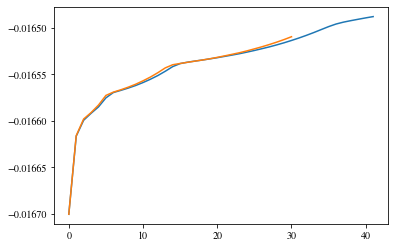

In [16]:
dbdy_WC = -9.8/1020*gridWC.derivative(dsWC.rho.isel(s_rho=-1), 'Y')
dbdy_NC = -9.8/1020*gridNC.derivative(dsNC.rho.isel(s_rho=-1), 'Y')

yl = range(500, 3500)
dsWC['rho_m'] = dsWC.rho.mean('xi_rho')
dbdy_WC_mean = (-9.8/1020*(dsWC.rho_m.isel(s_rho=-1, eta_rho=yl[-1]) - dsWC.rho_m.isel(s_rho=-1, eta_rho=yl[-0])))

dsNC['rho_m'] = dsNC.rho.mean('xi_rho')
dbdy_NC_mean = (-9.8/1020*(dsNC.rho_m.isel(s_rho=-1, eta_rho=yl[-1]) - dsNC.rho_m.isel(s_rho=-1, eta_rho=yl[-0])))

plt.plot(dbdy_WC_mean)
plt.plot(dbdy_NC_mean)



In [ ]:
b_grad_WC = dsWC.xroms.M2.isel( eta_rho=slice(500, 3500), s_w=-2)

In [ ]:
b_grad_NC = dsNC.xroms.M2.isel( eta_rho=slice(500, 3500), s_w=-2)
#b_grad_NC

In [ ]:
b_grad_WC_m = (b_grad_WC**2).mean(('eta_rho', 'xi_rho'))
b_grad_NC_m = (b_grad_NC**2).mean(('eta_rho', 'xi_rho'))
endday = 30
bg_WC = b_grad_WC_m.sel(ocean_time=(endday+360)*86400, method='nearest') - 0*b_grad_WC_m.sel(ocean_time=(5+360)*86400, method='nearest')
bg_NC = b_grad_NC_m.sel(ocean_time=(endday+360)*86400, method='nearest') - 0*b_grad_NC_m.sel(ocean_time=(5+360)*86400, method='nearest')
print(f'Ratio of gradients {bg_WC.values/bg_NC.values}')

In [ ]:
b_grad_WC_m = (b_grad_WC**2).mean(('eta_rho', 'xi_rho'))
b_grad_NC_m = (b_grad_NC**2).mean(('eta_rho', 'xi_rho'))

plt.plot(b_grad_WC_m)
plt.plot(b_grad_NC_m)

In [ ]:
endday = 30
bg_WC = b_grad_WC_m.sel(ocean_time=(endday+360)*86400, method='nearest') - b_grad_WC_m.sel(ocean_time=(5+360)*86400, method='nearest')
bg_NC = b_grad_NC_m.sel(ocean_time=(endday+360)*86400, method='nearest') - b_grad_NC_m.sel(ocean_time=(5+360)*86400, method='nearest')
print(f'Ratio of gradients {bg_WC.values/bg_NC.values}')

In [ ]:
#rdiff = dsWC.rho - dsNC.rho
#rdiff

In [ ]:
# PLOT HBL

plt.plot(dsWC.hbl.isel(eta_rho=slice(1000,3000)).mean(('eta_rho', 'xi_rho')))
plt.plot(dsNC.hbl.isel(eta_rho=slice(1000,3000)).mean(('eta_rho', 'xi_rho')))

### Try to look directly at EBF_g vs EBF_CFB

In [20]:
# Calculate the EBF
bx = xroms.to_rho(-9.8/1020*gridWC.derivative(dsWC.rho.isel(s_rho=-1), 'X'), gridWC)
by = xroms.to_rho(-9.8/1020*gridWC.derivative(dsWC.rho.isel(s_rho=-1), 'Y'), gridWC)
dsWC['bx'] = bx
dsWC['by'] = by
dsWC['EBF'] = (bx*xroms.to_rho(dsWC.svstr, gridWC) - by*xroms.to_rho(dsWC.sustr, gridWC))/(dsWC.f*1020)
dsWC['EBFm'] = (bx*1e-3*7*5 - by*1e-3*7*5)/(dsWC.f*1020)
dsWC['Nablab'] = np.sqrt(bx**2 + by**2)

bx = xroms.to_rho(-9.8/1020*gridNC.derivative(dsNC.rho.isel(s_rho=-1), 'X'), gridNC)
by = xroms.to_rho(-9.8/1020*gridNC.derivative(dsNC.rho.isel(s_rho=-1), 'Y'), gridNC)
dsNC['bx'] = bx
dsNC['by'] = by
dsNC['EBF'] = (bx*xroms.to_rho(dsNC.svstr, gridNC) - by*xroms.to_rho(dsNC.sustr, gridNC))/(dsNC.f*1020)
dsNC['Nablab'] = np.sqrt(bx**2 + by**2)

In [21]:
# Roughly estimate EBF_g
ustarwc = np.sqrt((xroms.to_rho(dsWC.sustr, gridWC)**2 + xroms.to_rho(dsWC.svstr, gridWC)**2)**(1/2)/1020)
coff = 0.05
nu = coff*ustarwc*dsWC.hbl

taug = -1020*nu*dsWC.Nablab/dsWC.f
dsWC['EBFg'] = taug*dsWC.Nablab/(dsWC.f*1020)
#dsWC['EBFg'] = -nu*dsWC.Nablab**2/(dsWC.f**2)
    
ustarnc = np.sqrt((xroms.to_rho(dsNC.sustr, gridNC)**2 + xroms.to_rho(dsNC.svstr, gridNC)**2)**(1/2)/1020)
nu = coff*ustarnc*dsNC.hbl

taug = -1020*nu*dsNC.Nablab/dsNC.f
dsNC['EBFg'] = taug*dsNC.Nablab/(dsNC.f*1020)
# dsNC['EBFg'] = -nu*dsNC.Nablab**2/dsNC.f**2

2022-08-08 16:17:47,131 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


2022-08-08 16:17:50,236 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-08-08 16:17:53,106 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-08-08 16:17:55,757 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-08-08 16:17:58,752 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-08-08 16:18:01,767 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2022-08-08 16:18:04,822 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2022-08-08 16:18:09,399 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2022-08-08 16:18:12,535 - distributed.utils_perf - WARNING - full garbage collections took

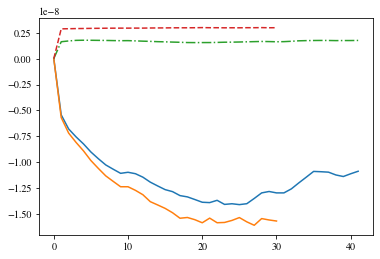

In [22]:
plt.plot(dsWC.EBFg.mean(('eta_rho', 'xi_rho')))
plt.plot(dsNC.EBFg.mean(('eta_rho', 'xi_rho')))
plt.plot(dsWC.EBF.mean(('eta_rho', 'xi_rho')), linestyle='-.')
plt.plot(dsNC.EBF.mean(('eta_rho', 'xi_rho')), linestyle='--')

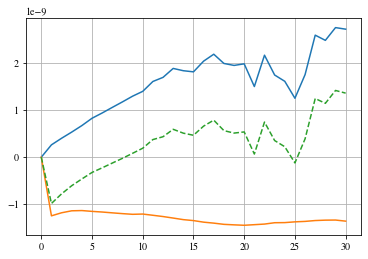

In [92]:
EBFgdiff = dsWC.EBFg.mean(('eta_rho', 'xi_rho')) - dsNC.EBFg.mean(('eta_rho', 'xi_rho'))
plt.plot(EBFgdiff)
EBFdiff = dsWC.EBF.mean(('eta_rho', 'xi_rho')) - dsNC.EBF.mean(('eta_rho', 'xi_rho'))
plt.plot(EBFdiff)
plt.plot(EBFgdiff+EBFdiff, linestyle='--')
plt.grid()

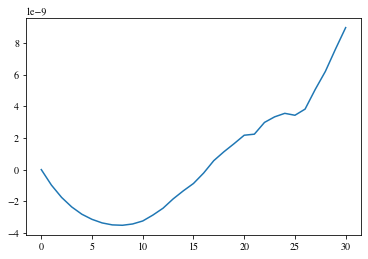

In [89]:
plt.plot(np.cumsum(EBFgdiff+EBFdiff))

In [17]:
from glob import glob
files = sorted(glob('../data/interim/JET_NML_CFB/pv*.nc'))
dsPV = xr.open_mfdataset(files[1:], combine='nested',concat_dim='time', parallel=True, data_vars='minimal', compat='override', coords='minimal')

yl = slice(0, 4000)
zl = slice(0, 100)
ts = slice(0, 41, 2)
PV_SERIES = dsPV.ertel.isel(eta_rho=yl, s_rho=zl, time=ts).sum(('s_rho', 'eta_rho', 'xi_rho')).compute()
dsPV


2022-08-08 16:16:43,491 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-08-08 16:16:45,536 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-08-08 16:16:47,766 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-08-08 16:16:50,648 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-08-08 16:16:52,619 - distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
2022-08-08 16:16:54,850 - distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
2022-08-08 16:16:56,891 - distributed.utils_perf - WARNING - full garbage collections took 15% CPU time recently (threshold: 10%)
2022-08-08 16:16:58,918 - distributed.utils_perf - WARNING - full garbage collections took

<xarray.Dataset>
Dimensions:     (xi_rho: 1002, eta_rho: 4002, s_rho: 100, time: 41)
Coordinates:
  * xi_rho      (xi_rho) int64 0 1 2 3 4 5 6 7 ... 995 996 997 998 999 1000 1001
  * eta_rho     (eta_rho) int64 0 1 2 3 4 5 6 ... 3996 3997 3998 3999 4000 4001
  * s_rho       (s_rho) float32 -0.995 -0.985 -0.975 ... -0.025 -0.015 -0.005
    x_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    y_rho       (eta_rho, xi_rho) float32 dask.array<chunksize=(4002, 1002), meta=np.ndarray>
    ocean_time  float64 ...
  * time        (time) float64 3.119e+07 3.197e+07 ... 3.18e+07 3.188e+07
    z_rho       (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(100, 4002, 1002), meta=np.ndarray>
    z_rho0      (s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(100, 4002, 1002), meta=np.ndarray>
Data variables:
    ertel       (time, s_rho, eta_rho, xi_rho) float64 dask.array<chunksize=(1, 100, 4002, 1002), meta=np.ndarray>

2022-08-08 16:19:47,841 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


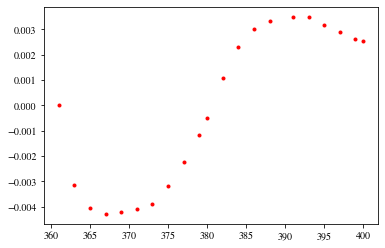

2022-08-08 16:19:49,940 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)


In [23]:
plt.plot(dsPV.time.isel(time=ts)/86400, PV_SERIES-PV_SERIES[0], color='r', marker='.', linestyle='')

2022-08-08 16:24:04,156 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-08-08 16:24:07,216 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-08-08 16:24:11,077 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-08-08 16:24:14,947 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-08-08 16:24:19,146 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-08-08 16:24:23,423 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-08-08 16:24:27,690 - distributed.utils_perf - WARNING - full garbage collections took 28% CPU time recently (threshold: 10%)
2022-08-08 16:24:31,980 - distributed.utils_perf - WARNING - full garbage collections took

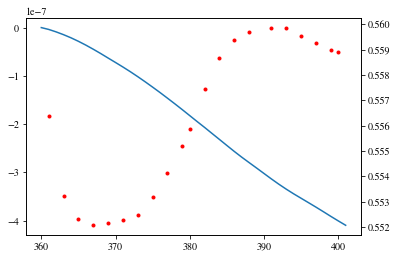

2022-08-08 16:25:25,683 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-08-08 16:25:28,044 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-08-08 16:25:30,546 - distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
2022-08-08 16:25:32,862 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-08-08 16:25:35,327 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-08-08 16:25:37,674 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-08-08 16:25:40,210 - distributed.utils_perf - WARNING - full garbage collections took 27% CPU time recently (threshold: 10%)
2022-08-08 16:25:42,604 - distributed.utils_perf - WARNING - full garbage collections took

In [29]:
# plt.plot(np.cumsum(EBFgdiff+EBFdiff))
plt.plot(dsWC.ocean_time/86400, np.cumsum(dsWC.EBFg.mean(('eta_rho', 'xi_rho')) + dsWC.EBF.mean(('eta_rho', 'xi_rho'))))
ax1 = plt.gca()
ax2 = ax1.twinx()
ax2.plot(dsPV.time.isel(time=ts)/86400, PV_SERIES, color='r', marker='.', linestyle='')

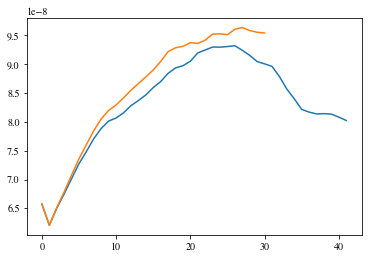

In [83]:
plt.plot(dsWC.Nablab.isel(eta_rho=yl).mean(('xi_rho', 'eta_rho')))
plt.plot(dsNC.Nablab.isel(eta_rho=yl).mean(('xi_rho', 'eta_rho')))

# LOOK AT KE

In [ ]:
KE_WC = dsWC.xroms.KE.isel(s_rho=-1, eta_rho=slice(1000,3000)).compute()

In [ ]:
KE_NC = dsNC.xroms.KE.isel(s_rho=-1, eta_rho=slice(1000,3000)).compute()

In [ ]:
KE_WC_m = KE_WC.mean(('eta_rho', 'xi_rho'))
KE_NC_m = KE_NC.mean(('eta_rho', 'xi_rho'))

plt.plot(KE_WC_m)
plt.plot(KE_NC_m)

KE_WC_v = KE_WC_m.sel(ocean_time=(20+360)*86400, method='nearest') - KE_WC_m.sel(ocean_time=(5+360)*86400, method='nearest')
KE_NC_v = KE_NC_m.sel(ocean_time=(20+360)*86400, method='nearest') - KE_NC_m.sel(ocean_time=(5+360)*86400, method='nearest')


print(f'Ratio of gradients {KE_WC_v.values/KE_NC_v.values}')

# Look at wind work

In [ ]:
# Wind work
yl = slice(1000,3000)
ww_WC = gridWC.average(dsWC.sustr.isel(eta_rho=yl)*dsWC.u.isel(s_rho=-1, eta_rho=yl), ('X','Y')) + gridWC.average(dsWC.svstr.isel(eta_v=yl)*dsWC.v.isel(s_rho=-1, eta_v=yl), ('X','Y'))
ww_NC = gridNC.average(dsNC.sustr.isel(eta_rho=yl)*dsNC.u.isel(s_rho=-1, eta_rho=yl), ('X','Y')) + gridNC.average(dsNC.svstr.isel(eta_v=yl)*dsNC.v.isel(s_rho=-1, eta_v=yl), ('X','Y'))

plt.plot(dsWC.ocean_time/86400, ww_WC)
plt.plot(dsNC.ocean_time/86400, ww_NC)

print(f'Ratio of coupled/uncoupled wind work: {ww_WC.values[-1]/ww_NC.values[-1]}')

## MISC

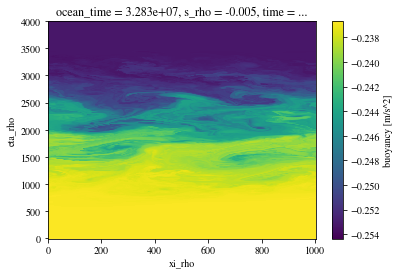

In [109]:
xroms.buoyancy(dsWC.rho, 1020).isel(s_rho=-1, ocean_time=20).plot()

2022-08-08 16:47:04,796 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:47:09,187 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:47:13,536 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)


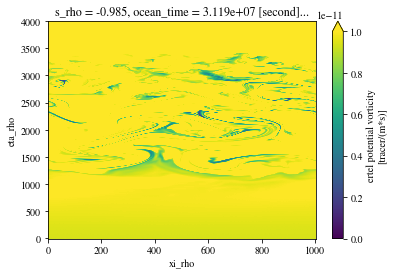

2022-08-08 16:47:18,850 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-08-08 16:47:22,353 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:47:25,992 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-08-08 16:47:29,592 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-08-08 16:47:33,005 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-08-08 16:47:36,580 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-08-08 16:47:40,011 - distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
2022-08-08 16:47:43,664 - distributed.utils_perf - WARNING - full garbage collections took

In [54]:
dsPV.ertel.isel(s_rho=1, time=20).plot(vmin=0, vmax=1e-11)


2022-08-08 16:45:09,490 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-08-08 16:45:13,872 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:45:18,449 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)


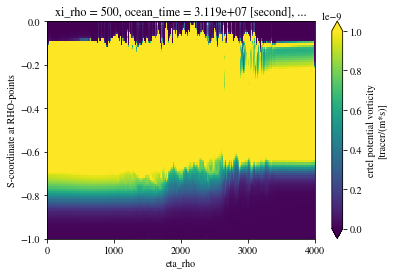

2022-08-08 16:45:22,440 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:45:25,877 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:45:29,338 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:45:32,744 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:45:36,214 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:45:39,496 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:45:42,892 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:45:46,183 - distributed.utils_perf - WARNING - full garbage collections took

In [53]:
dsPV.ertel.isel(xi_rho=500, time=5).plot(vmin=0, vmax=1e-9)


2022-08-08 16:30:43,194 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-08-08 16:30:46,678 - distributed.utils_perf - WARNING - full garbage collections took 33% CPU time recently (threshold: 10%)
2022-08-08 16:30:50,559 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-08-08 16:30:54,573 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-08-08 16:30:58,502 - distributed.utils_perf - WARNING - full garbage collections took 32% CPU time recently (threshold: 10%)
2022-08-08 16:31:02,555 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-08-08 16:31:06,366 - distributed.utils_perf - WARNING - full garbage collections took 31% CPU time recently (threshold: 10%)
2022-08-08 16:31:10,525 - distributed.utils_perf - WARNING - full garbage collections took

2022-08-08 16:31:22,219 - distributed.utils_perf - WARNING - full garbage collections took 30% CPU time recently (threshold: 10%)


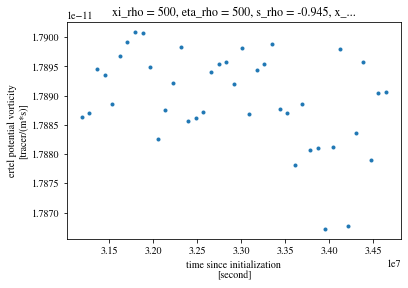

In [39]:
dsPV.ertel.isel(eta_rho=500, xi_rho=500, s_rho=5).plot(marker='.', linestyle='')

2022-08-08 16:50:21,820 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-08-08 16:50:25,920 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-08-08 16:50:30,225 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)


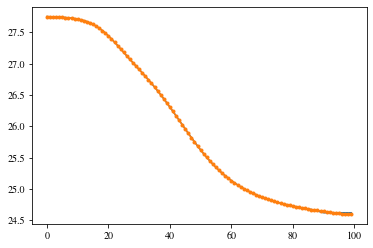

2022-08-08 16:50:34,231 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-08-08 16:50:37,901 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-08-08 16:50:41,659 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-08-08 16:50:45,325 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-08-08 16:50:49,079 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-08-08 16:50:52,589 - distributed.utils_perf - WARNING - full garbage collections took 40% CPU time recently (threshold: 10%)
2022-08-08 16:50:56,548 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:51:00,150 - distributed.utils_perf - WARNING - full garbage collections took

In [55]:
plt.plot(dsWC.rho.isel(eta_rho=500, xi_rho=500, ocean_time=30))
plt.plot(rst.temp.isel(eta_rho=500, xi_rho=500), marker='.')

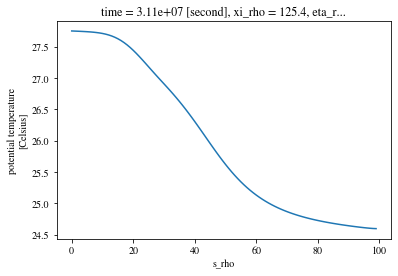

2022-08-08 16:36:06,875 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:36:10,165 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:36:13,284 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:36:16,396 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:36:19,514 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)
2022-08-08 16:36:22,822 - distributed.utils_perf - WARNING - full garbage collections took 39% CPU time recently (threshold: 10%)


In [46]:
rst = xr.open_dataset('../data/model/JET_NML_CFB/jet_rst_NML_4.nc')
rst.temp.isel(eta_rho=500, xi_rho=500).plot()